# Лабораторная работа 5. Анпилов Кирилл

# Импорт библиотек

In [2]:
import torch
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000

from tqdm.auto import tqdm

from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data
from torch_geometric.loader import NeighborLoader




from torch_geometric.datasets import KarateClub
from torch_geometric.datasets import Reddit

from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import to_networkx

from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv

from IPython.display import HTML

RANDOM_SEED = 42


# Set the seed value all over the place to make this reproducible.
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Задание:
- Изучить статью о GCN по ссылке: https://nuancesprog.ru/p/18983/ в том числе изучить описание датасета, который используется в данной статье.

- Скачать пример кода GCN из указанной статьи и проверить его работоспособность

- Заменить в примере кода исходный датасет по карате клубу на любой другой датасет и решить задачу классификации (в новом датасете должны быть как минимум 4 категории сущностей, которые подлежат классификации).

- Сравнить точность GCN с другими моделями

## Проверка KarateClub

In [4]:
dataset = KarateClub()

In [5]:
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Number of graphs: 1
Number of features: 34
Number of classes: 4


data.x: Матрица признаков узлов (node features). В данном случае, каждый узел представлен своим уникальным идентификатором, но это может быть любая другая информация о каждом узле, например, возраст, пол, интересы в социальной сети и т. д.

data.edge_index: Матрица ребер (edge connectivity). Это представление графа в виде списка ребер, где каждая колонка представляет начальный узел, а каждая строка представляет конечный узел.

data.y: Целевая переменная или метки (node labels). В данном случае, это метки, указывающие на принадлежность к одной из двух групп в каратэ-клубе (имеется в виду структура графа - в данном клубе произошло разделение на две группы, и метки обозначают эту принадлежность).

In [6]:
dataset[0]

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [7]:
print(f'Graph: {dataset[0]}')

Graph: Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [8]:
data = dataset[0]
print(f'x = {data.x.shape}')
print(data.x)

x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


Признаков нет, просто диагональ

In [9]:
len(data.edge_index)

2

In [10]:
print(f'edge_index = {data.edge_index.shape}')
print(data.edge_index)

edge_index = torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3, 

In [11]:
A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
print(f'A = {A.shape}')
print(A)

A = (34, 34)
[[0 1 1 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


In [12]:
print(f'y = {data.y.shape}')
print(data.y)

y = torch.Size([34])
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


In [13]:
print(f'train_mask = {data.train_mask.shape}')
print(data.train_mask)

train_mask = torch.Size([34])
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])


In [14]:
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


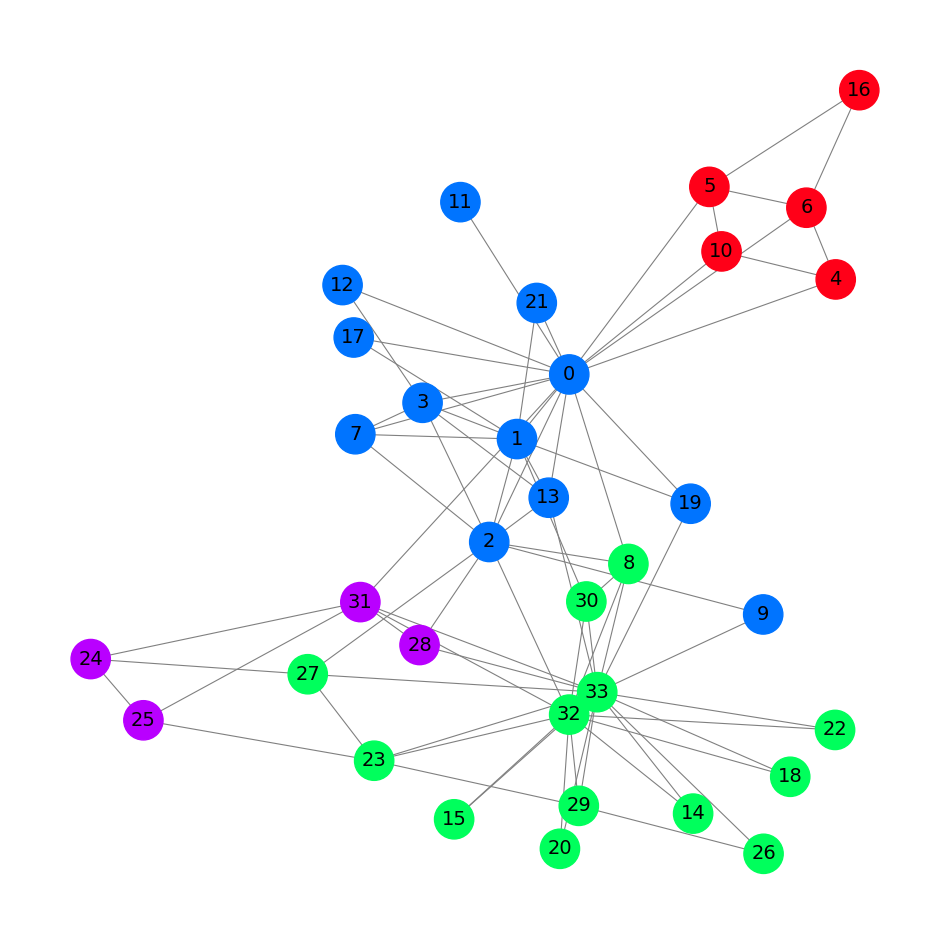

In [15]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

In [16]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, dataset.num_classes)
    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

In [17]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
model

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)

### Обучение

In [18]:
# Расчет точности
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Данные для анимаций
embeddings = []
losses = []
accuracies = []
outputs = []



model.train()
for epoch in range(200):
    optimizer.zero_grad()
    h, z = model(data.x, data.edge_index)
    loss = criterion(z, data.y)
    acc = accuracy(z.argmax(dim=1), data.y)
    loss.backward()
    optimizer.step()

    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')


Epoch   0 | Loss: 1.42 | Acc: 11.76%
Epoch  10 | Loss: 1.28 | Acc: 50.00%
Epoch  20 | Loss: 1.13 | Acc: 44.12%
Epoch  30 | Loss: 0.94 | Acc: 73.53%
Epoch  40 | Loss: 0.68 | Acc: 82.35%
Epoch  50 | Loss: 0.49 | Acc: 85.29%
Epoch  60 | Loss: 0.38 | Acc: 85.29%
Epoch  70 | Loss: 0.30 | Acc: 85.29%
Epoch  80 | Loss: 0.22 | Acc: 85.29%
Epoch  90 | Loss: 0.16 | Acc: 100.00%
Epoch 100 | Loss: 0.11 | Acc: 100.00%
Epoch 110 | Loss: 0.08 | Acc: 100.00%
Epoch 120 | Loss: 0.06 | Acc: 100.00%
Epoch 130 | Loss: 0.05 | Acc: 100.00%
Epoch 140 | Loss: 0.04 | Acc: 100.00%
Epoch 150 | Loss: 0.03 | Acc: 100.00%
Epoch 160 | Loss: 0.03 | Acc: 100.00%
Epoch 170 | Loss: 0.02 | Acc: 100.00%
Epoch 180 | Loss: 0.02 | Acc: 100.00%
Epoch 190 | Loss: 0.02 | Acc: 100.00%


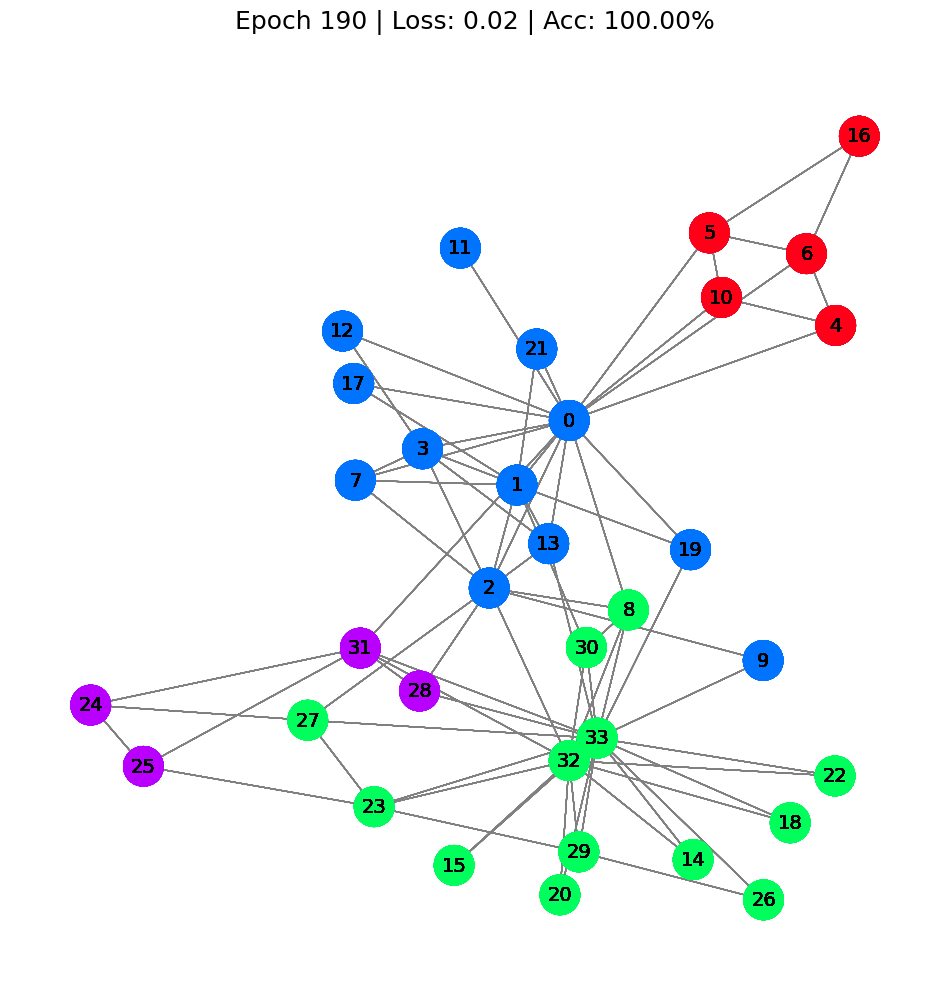

In [21]:
def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=800,
                    node_color=outputs[i],
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=14
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=20)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')

anim = animation.FuncAnimation(fig, animate, \
            np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())
display(html)
plt.show()

## Reddit

Этот датасет представляет собой набор данных Reddit, взятый из статьи "Inductive Representation Learning on Large Graphs". Датасет содержит посты Reddit, принадлежащие разным сообществам.

Основные параметры инициализации этого класса:

- `root` (str): Корневой каталог, в котором должен быть сохранен датасет.
- `transform` (callable, optional): Функция/трансформация, которая принимает объект Data и возвращает преобразованную версию. Объект данных будет преобразован перед каждым доступом. (по умолчанию: None)
- `pre_transform` (callable, optional): Функция/трансформация, которая принимает объект Data и возвращает преобразованную версию. Объект данных будет преобразован перед сохранением на диск. (по умолчанию: None)
- `force_reload` (bool, optional): Флаг, указывающий, нужно ли повторно обработать датасет. (по умолчанию: False)

Этот датасет предназначен для исследования и разработки моделей машинного обучения, способных анализировать и обрабатывать графы, представляющие сообщества и взаимодействия пользователей на платформе Reddit.

- `data.x`: Матрица признаков узлов (node features).
- `data.edge_index`: Матрица ребер (edge connectivity).
- `data.y`: Целевая переменная или метки (node labels). В данном случае, это метки, указывающие транслирует ли пользователь контент для взрослых.

In [3]:
dataset_reddit = Reddit("")

In [4]:
dataset_reddit.num_features, dataset_reddit.num_classes

(602, 41)

In [5]:
data_tensor = torch.load('processed/data.pt')

In [6]:
data = data_tensor[0]
data

{'x': tensor([[ 1.2334,  9.0430, -0.9233,  ..., -0.2579,  0.3112, -0.3772],
         [-0.1386, -0.2022,  0.1277,  ...,  0.1563,  0.1048, -0.6534],
         [-0.1330, -0.1962, -0.0296,  ...,  0.0358,  0.2864,  0.2744],
         ...,
         [-0.0614, -0.2022,  0.9698,  ...,  1.1064, -1.4323, -0.2398],
         [-0.1606, -0.2022, -0.0892,  ...,  0.7440, -0.5046, -2.2288],
         [ 0.0929,  0.2822,  0.1768,  ...,  0.2196,  0.5967,  0.5588]]),
 'edge_index': tensor([[     0,      0,      0,  ..., 232964, 232964, 232964],
         [   242,    249,    524,  ..., 231806, 232594, 232634]]),
 'y': tensor([30, 17, 18,  ...,  3, 13, 13]),
 'train_mask': tensor([False,  True, False,  ...,  True,  True, False]),
 'val_mask': tensor([False, False, False,  ..., False, False, False]),
 'test_mask': tensor([ True, False,  True,  ..., False, False,  True])}

In [7]:
data['x']

tensor([[ 1.2334,  9.0430, -0.9233,  ..., -0.2579,  0.3112, -0.3772],
        [-0.1386, -0.2022,  0.1277,  ...,  0.1563,  0.1048, -0.6534],
        [-0.1330, -0.1962, -0.0296,  ...,  0.0358,  0.2864,  0.2744],
        ...,
        [-0.0614, -0.2022,  0.9698,  ...,  1.1064, -1.4323, -0.2398],
        [-0.1606, -0.2022, -0.0892,  ...,  0.7440, -0.5046, -2.2288],
        [ 0.0929,  0.2822,  0.1768,  ...,  0.2196,  0.5967,  0.5588]])

In [8]:
data['x'].shape

torch.Size([232965, 602])

In [9]:
data['edge_index']

tensor([[     0,      0,      0,  ..., 232964, 232964, 232964],
        [   242,    249,    524,  ..., 231806, 232594, 232634]])

In [10]:
data['edge_index'].shape

torch.Size([2, 114615892])

In [11]:
data['y']

tensor([30, 17, 18,  ...,  3, 13, 13])

### Создание класса Data

In [12]:
data = Data(x=data['x'],
            edge_index=data['edge_index'],
            y = data['y'],
            train_mask = data['train_mask'],
            val_mask = data['val_mask'],
            test_mask = data['test_mask'])

### сlass NeighborLoader

In [ ]:
kwargs = {'batch_size': 256}
train_loader = NeighborLoader(data, input_nodes=data.train_mask,
                              num_neighbors=[25, 10], shuffle=True, **kwargs)

test_loader = NeighborLoader(data, input_nodes=data.test_mask,
                              num_neighbors=[25, 10], **kwargs)

val_loader = NeighborLoader(data, input_nodes=data.val_mask,
                              num_neighbors=[25, 10], **kwargs)


/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [1]:
for i in train_loader:
    print(i)
    break

NameError: name 'train_loader' is not defined

In [ ]:
train_dataset = Dataset(data.x[data.train_mask], data.edge_index, data.y[data.train_mask])
test_dataset = Dataset(data.x[data.test_mask], data.edge_index, data.y[data.test_mask])
val_dataset = Dataset(data.x[data.val_mask], data.edge_index, data.y[data.val_mask])

In [ ]:
BATCH_SIZE = 10

train_dataloader = DataLoader(train_dataset,  batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

### Модель

`GCNConv` - это класс из библиотеки PyTorch Geometric, представляющий слой графовой свертки (Graph Convolutional Layer). Этот слой используется в графовых нейронных сетях (Graph Neural Networks, GNN) для обработки графовых данных.

Вот краткое объяснение того, как работает `GCNConv`:

1. **Инициализация**: При инициализации слоя `GCNConv` вы указываете количество входных и выходных признаков. Например, в вашем примере количество входных признаков равно `dataset_twitch.num_features`, и количество выходных каналов равно 3.

2. **Прямой проход (forward pass)**: Во время прямого прохода слой `GCNConv` выполняет следующие шаги:
   - **Агрегация признаков узлов**: Для каждого узла графа `GCNConv` агрегирует признаки его соседей и самого узла. Это происходит путем умножения признаков соседних узлов на их веса и суммирования результатов.
   - **Преобразование агрегированных признаков**: После агрегации признаков `GCNConv` применяет линейное преобразование (включая веса и смещение) к агрегированным признакам для создания новых признаков узлов.
   - **Функция активации**: Обычно к результатам применяется нелинейная функция активации, например, ReLU (Rectified Linear Unit), чтобы внести нелинейность в модель.

3. **Результат**: В результате прямого прохода `GCNConv` создает новые признаки узлов, которые затем передаются следующему слою в модели.

4. **Обратное распространение ошибки (backpropagation)**: Во время обучения модели градиенты ошибки вычисляются и передаются обратно через слой `GCNConv`, чтобы обновить его веса и улучшить качество предсказаний модели.

Ключевая идея слоя графовой свертки (GCN) заключается в том, что он учитывает структуру графа при агрегации признаков узлов, что позволяет модели лучше улавливать информацию о связях между узлами в графе.

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset_reddit.num_features, 128)
        self.fc1 = Linear(128, 64)
        self.fc2 = Linear(64, dataset_reddit.num_classes)
    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        h = self.fc1(h)
        z = self.fc2(h)
        return z, h




In [ ]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
n_epochs = 10
model

GCN(
  (gcn): GCNConv(602, 128)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=41, bias=True)
)

In [ ]:
def train(model, optimizer, criterion, n_epochs, train_loader, test_loader):


    loss_train = []
    accuracy_train = []

    for epoch in range(n_epochs):
        model.train()
        for batch in tqdm(train_loader, desc=f"Training epoch {epoch + 1}/{n_epochs}"):

            inputs = batch.x
            edge_index = batch.edge_index
            labels = batch.y
            output, h = model(inputs, edge_index)

            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


        model.eval()

        correct = 0
        total = 0

        with torch.no_grad():
          for batch in tqdm(test_loader, desc=f"Testing epoch {epoch + 1}/{n_epochs}"):

            inputs = batch.x
            edge_index = batch.edge_index
            labels = batch.y
            output, h = model(inputs, edge_index)

            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = correct / total
        accuracy_train.append(test_accuracy)
        print('Epoch [{}/{}], Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(epoch + 1, n_epochs, loss.item(), test_accuracy * 100))
        loss_train.append(loss.item())


In [ ]:
dataset_reddit.num_features

602

In [ ]:
for i in train_dataloader:
    print(i['X'].shape)
    break

torch.Size([10, 602])


### Обучение

In [ ]:
train(model, optimizer, criterion, n_epochs, train_dataloader, test_dataloader)

Training epoch 1/10:   0%|          | 0/15344 [00:00<?, ?it/s]

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 10 but got size 2 for tensor number 1 in the list.

In [ ]:
# Расчет точности
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Данные для анимаций
embeddings = []
losses = []
accuracies = []
outputs = []

print(

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    h, z = model(data.x, data.edge_index)
    loss = criterion(z, data.y)
    acc = accuracy(z.argmax(dim=1), data.y)
    loss.backward()
    optimizer.step()

    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))

    print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')


In [ ]:
def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=80,
                    node_color=outputs[i],
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=10
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',fontsize=20, pad=20)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')

anim = animation.FuncAnimation(fig, animate, np.arange(0, 200, 10), interval=500, repeat=False)
html = HTML(anim.to_html5_video())
display(html)
plt.clf()
